<a href="https://colab.research.google.com/github/Areefahnk/TacklingCustomerSupport_NLP/blob/main/CustomerComplaint_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
seed = 69 # set random seed for whole document

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

# Natural Language Processing Thingamajibs
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec, word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import gensim

# Classifiers
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Lifesaver
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/complaints.csv')

In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,13-06-2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,13-06-2019,Closed with explanation,Yes,NaN,3274605
1,01-11-2019,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,01-11-2019,Closed with explanation,Yes,NaN,3425257
2,01-04-2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,01-04-2019,Closed with explanation,Yes,NaN,3198225
3,15-10-2021,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,ENCORE CAPITAL GROUP INC.,MA,1103,NaN,NaN,Web,15-10-2021,Closed with explanation,Yes,NaN,4813701
4,28-10-2021,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",CA,95206,NaN,NaN,Web,28-10-2021,In progress,Yes,NaN,4854258


**Data Cleaning**

In [ ]:
# Column Cleaning First. Columns are super nastily named
df.rename(columns={'Date received':'DATE_RECEIVED',
                  'Product':'PRODUCT',
                  'Sub-product':'SUB_PRODUCT',
                  'Issue':'ISSUE',
                  'Sub-issue':'SUB_ISSUE',
                  'Consumer complaint narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'Company public response':'COMPANY_PUBLIC_RESPONSE',
                   'Company':'COMPANY',
                   'State':'STATE',
                   'ZIP code':'ZIP_CODE',
                   'Tags':'TAGS',
                   'Consumer consent provided?':'CONSUMER_CONSENT_PROVIDED',
                   'Subbmited via':'SUBMITTED_VIA',
                   'Date sent to company':'DATE_SENT_TO_COMPANY',
                   'Company response to consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'Timely response?':'TIMELY_RESPONSE',
                   'Consumer disputed?':'CONSUMER_DISPUTED',
                   'Complaint ID':'COMPLAINT_ID'
                  }, inplace=True)

In [ ]:
df.head()

,DATE_RECEIVED,PRODUCT,SUB_PRODUCT,ISSUE,SUB_ISSUE,CONSUMER_COMPLAINT_NARRATIVE,COMPANY_PUBLIC_RESPONSE,COMPANY,STATE,ZIP_CODE,TAGS,CONSUMER_CONSENT_PROVIDED,Submitted via,DATE_SENT_TO_COMPANY,COMPANY_RESPONSE_TO_CONSUMER,TIMELY_RESPONSE,CONSUMER_DISPUTED,COMPLAINT_ID
0,13-06-2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,13-06-2019,Closed with explanation,Yes,NaN,3274605
1,01-11-2019,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,01-11-2019,Closed with explanation,Yes,NaN,3425257
2,01-04-2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,01-04-2019,Closed with explanation,Yes,NaN,3198225
3,15-10-2021,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,ENCORE CAPITAL GROUP INC.,MA,1103,NaN,NaN,Web,15-10-2021,Closed with explanation,Yes,NaN,4813701
4,28-10-2021,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",CA,95206,NaN,NaN,Web,28-10-2021,In progress,Yes,NaN,4854258


**Dropping all rows that do not have Customer Complaint entries in them**

In [ ]:
df.dropna(axis=0, subset=['CONSUMER_COMPLAINT_NARRATIVE'], 
          inplace=True)

**Subsetting Dataframe for Text Multi-Classification Problem**

In [ ]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_product_and_complaint = df[['PRODUCT', 'CONSUMER_COMPLAINT_NARRATIVE']]

# Renaming columns to something easier
df_product_and_complaint.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 
df.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_product_and_complaint.head()

,PRODUCT,CONSUMER_COMPLAINT
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
12,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...
13,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...
15,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...
18,"Credit reporting, credit repair services, or o...",Receiving daily telephone call ( s ) from XXXX...


In [ ]:
df=df_product_and_complaint

In [ ]:
df.head()

,PRODUCT,CONSUMER_COMPLAINT
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
12,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...
13,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...
15,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...
18,"Credit reporting, credit repair services, or o...",Receiving daily telephone call ( s ) from XXXX...


**Exploring Consumer Complaints**

In [ ]:
# Exploring the number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_and_complaint['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_and_complaint['PRODUCT'].nunique())
print('--------------')

--------------
Categories in PRODUCT column:
--------------

['Vehicle loan or lease'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card'
 'Money transfer, virtual currency, or money service' 'Mortgage'
 'Payday loan, title loan, or personal loan' 'Debt collection'
 'Checking or savings account' 'Student loan' 'Consumer Loan'
 'Money transfers' 'Credit card' 'Bank account or service'
 'Credit reporting' 'Prepaid card' 'Payday loan' 'Other financial service'
 'Virtual currency'] 

--------------
# of unique categories:  18
--------------


We see that some of the categories are repeated.
'Credit card' vs 'Credit card or prepaid card'
'Prepaid card' vs 'Credit card or prepaid card'
'Credit reporting' vs 'Credit reporting, credit repair services, or other personal consumer reports'
'Money transfers' vs 'Money transfer, virtual currency, or money service'
'Payday loan' vs 'Payday loan, title loan, or personal loan'
'Virtual currency' vs 'Money transfer, virtual currency, or money service' 'Money transfers'
There seems to be some sort of overlap between the categories, and I have no freakin clue why it is put this way. So why don't we simplify our problem by combining these categories together?

But of course - let us do some data visualizations

**DATA VISUALIZATION**

**Data Visualization on Categories in PRODUCT**

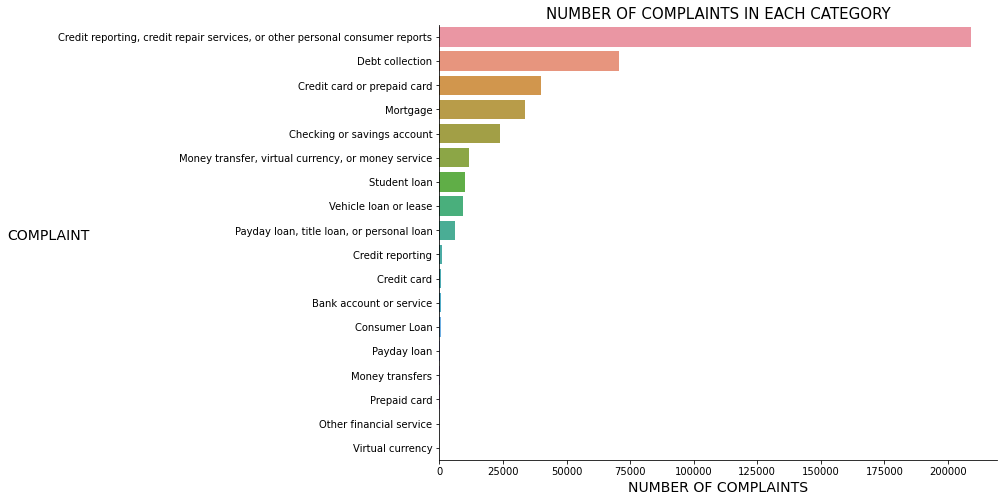

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint, 
                   order=df_product_and_complaint['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_of_uncombined_class.png', transparency=True)

In [ ]:
print('Number of rows in Dataframe: ', len(df_product_and_complaint))

Number of rows in Dataframe:  416410


**DataFrame Reduction (else we won't even be able to do processing)**

**Category Dropping**

In [ ]:
# Pre-drop category value_counts
df_product_and_complaint.PRODUCT.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    208947
Debt collection                                                                  70465
Credit card or prepaid card                                                      39764
Mortgage                                                                         33558
Checking or savings account                                                      23645
Money transfer, virtual currency, or money service                               11465
Student loan                                                                      9920
Vehicle loan or lease                                                             9215
Payday loan, title loan, or personal loan                                         6147
Credit reporting                                                                  1063
Credit card                                                                        788
Bank account or service                    

In [ ]:
# Dropping rows with the aggregated columns
df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Credit reporting, credit repair services, or other personal consumer reports'].index, 
    inplace=True) # credit_aggregated

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Credit card or prepaid card'].index, 
    inplace=True) # cred_or_prepaid

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Money transfer, virtual currency, or money service'].index, 
    inplace=True) # money_virtual_service

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Payday loan, title loan, or personal loan'].index, 
    inplace=True) # payday_title_personal_loan

**Visualizing Leftover Categories (after dropping the ones stated above)**

Text(0.5, 0, 'NUMBER OF COMPLAINTS')

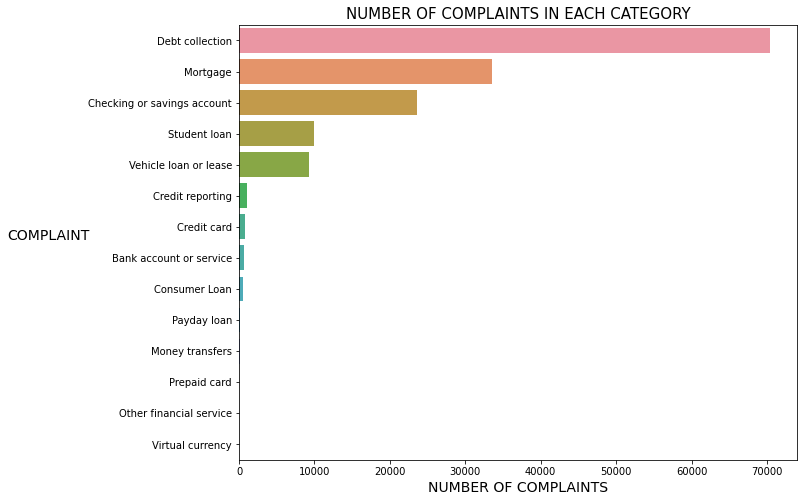

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint, 
                   order=df_product_and_complaint['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

In [ ]:

# Checking Length of df now
df_product_and_complaint.info()

# It's still quite a sizeable amount that my computer can't take. So we have to drop more.
# We want to reduce it to less than 50k entries

# LOL good job surface pro

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150087 entries, 1 to 1048561
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   PRODUCT             150087 non-null  object
 1   CONSUMER_COMPLAINT  150087 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
df_product_and_complaint.PRODUCT.value_counts()

Debt collection                70465
Mortgage                       33558
Checking or savings account    23645
Student loan                    9920
Vehicle loan or lease           9215
Credit reporting                1063
Credit card                      788
Bank account or service          596
Consumer Loan                    487
Payday loan                      144
Money transfers                  111
Prepaid card                      57
Other financial service           36
Virtual currency                   2
Name: PRODUCT, dtype: int64

**Combining Categories**

In [ ]:

df_product_and_complaint.replace('Student loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Consumer Loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Payday loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Vehicle loan or lease', 'Loan', inplace=True)

# Placing Virtual currency into other financial service
df_product_and_complaint.replace('Virtual currency', 'Other financial service', inplace=True)

**Leftover Categories Dataframe Reduction**

In [ ]:
df_product_and_complaint.PRODUCT.value_counts()

Debt collection                70465
Mortgage                       33558
Checking or savings account    23645
Loan                           19766
Credit reporting                1063
Credit card                      788
Bank account or service          596
Money transfers                  111
Prepaid card                      57
Other financial service           38
Name: PRODUCT, dtype: int64

**df_product_and_complaint.info()  # 290k rows.**

In [ ]:
df_product_and_complaint.info()  # 290k rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150087 entries, 1 to 1048561
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   PRODUCT             150087 non-null  object
 1   CONSUMER_COMPLAINT  150087 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
# Reducing dataframe to 30k entries
# Need to reduce all categories by 90%

percentage_reduction = 0.9

# Debt Collection Reduction
df_product_and_complaint_reduced = \
df_product_and_complaint.drop(
    df_product_and_complaint[df_product_and_complaint['PRODUCT'] == 'Debt collection'].sample(frac=percentage_reduction).index)

# Mortgage Reduction
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Mortgage'].sample(frac=percentage_reduction).index)

# Loan
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Loan'].sample(frac=percentage_reduction).index)

# Credit reporting
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Credit reporting'].sample(frac=percentage_reduction).index)

# Credit card
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Credit card'].sample(frac=percentage_reduction).index)

# Checking or savings account
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Checking or savings account'].sample(frac=percentage_reduction).index)

# Bank account or service
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Bank account or service'].sample(frac=percentage_reduction).index)

# # Money transfers (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Money transfers'].sample(frac=.9).index)

# # Prepaid card (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Prepaid card'].sample(frac=.9).index)

# # Other financial service (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Other financial service'].sample(frac=.9).index)

In [ ]:
df_product_and_complaint_reduced.PRODUCT.value_counts()

Debt collection                7047
Mortgage                       3356
Checking or savings account    2365
Loan                           1977
Money transfers                 111
Credit reporting                106
Credit card                      79
Bank account or service          60
Prepaid card                     57
Other financial service          38
Name: PRODUCT, dtype: int64

In [ ]:
df_product_and_complaint_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15196 entries, 73 to 1048486
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PRODUCT             15196 non-null  object
 1   CONSUMER_COMPLAINT  15196 non-null  object
dtypes: object(2)
memory usage: 356.2+ KB


In [ ]:
# Exploring the new number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_and_complaint_reduced['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_and_complaint_reduced['PRODUCT'].nunique())
print('--------------')

# Great! Now we are down to 10 classes.

--------------
Categories in PRODUCT column:
--------------

['Debt collection' 'Loan' 'Checking or savings account' 'Mortgage'
 'Money transfers' 'Credit reporting' 'Prepaid card'
 'Other financial service' 'Credit card' 'Bank account or service'] 

--------------
# of unique categories:  10
--------------


**Data Visualizing on newly combined classes**

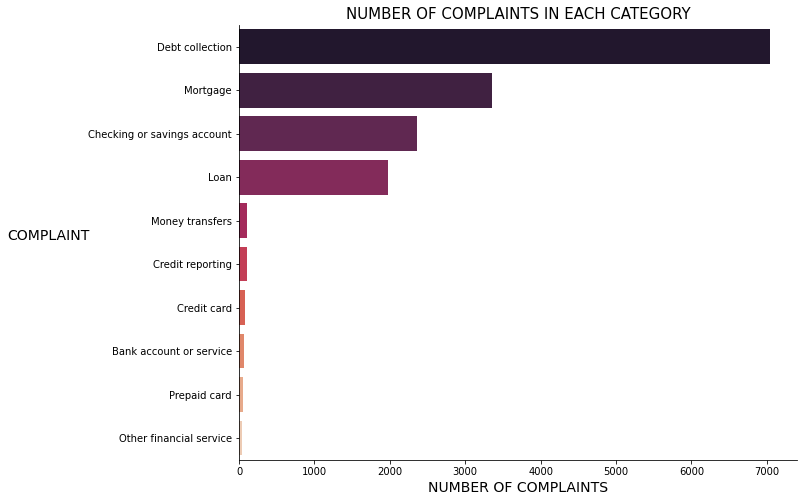

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint_reduced, 
                   order=df_product_and_complaint_reduced['PRODUCT'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

**Label Encoding Categories**

In [ ]:
# Applying encoding to the PRODUCT column
df_product_and_complaint_reduced['PRODUCT_ID'] = df_product_and_complaint_reduced['PRODUCT'].factorize()[0] 

#.factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the PRODUCT column


# Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
category_id_df = df_product_and_complaint_reduced[['PRODUCT', 'PRODUCT_ID']].drop_duplicates()


# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
id_to_category = dict(category_id_df[['PRODUCT_ID', 'PRODUCT']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

# New dataframe
df_product_and_complaint_reduced.head(10)

,PRODUCT,CONSUMER_COMPLAINT,PRODUCT_ID
73,Debt collection,"In XXXX, I started receiving mail and phone ca...",0
145,Debt collection,I was a curent Section8 government program att...,0
214,Loan,I attended XXXX XXXX University from the fall ...,1
356,Checking or savings account,"Account shut down due to "" XXXX '' the CSR 's ...",2
376,Checking or savings account,Upon learning of a fraudulent account opened u...,2
378,Debt collection,Premium Asset Services LLC has violated multip...,0
380,Debt collection,"At XXXX hours on XXXX XX/XX/2019, I called Cre...",0
392,Debt collection,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, GA XXXX CR...",0
446,Loan,I have been harassed via phone by XXXX XXXX wi...,1
524,Debt collection,What Is this complain about? \n\nPre-XXXX Suc...,0


In [ ]:
# We still get the same length as per the original df.
len(df_product_and_complaint_reduced)

15196

In [ ]:
# Reviewing our Loaded Dataframe
print(df_product_and_complaint_reduced.info())
print('--------------------------------------------------------------------------------------')
print(df_product_and_complaint_reduced.head().to_string())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15196 entries, 73 to 1048486
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PRODUCT             15196 non-null  object
 1   CONSUMER_COMPLAINT  15196 non-null  object
 2   PRODUCT_ID          15196 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
--------------------------------------------------------------------------------------
                         PRODUCT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

**Text Pre-Processing**

In [ ]:
# Looking at a sample text
sample_complaint = list(df_product_and_complaint_reduced.CONSUMER_COMPLAINT[:5])[4]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint = []
list_sample_complaint.append(sample_complaint)
list_sample_complaint

['Upon learning of a fraudulent account opened under my name, I contacted Wells Fargo multiple times. In person at a branch and over the phone and Wells Fargo continues to allow fraudulent activity! \nI have filed paperwork with Wells Fargo I have filed paperwork with credit bureaus and police departments. \n\nThere is an internal worker of Wells Fargo that is assisting with the fraud under my name. Not only have they continued to contact me but my information in system has been changed also!']

In [ ]:

# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf3 = TfidfVectorizer(stop_words='english')
check3 = tf_idf3.fit_transform(list_sample_complaint)

print(tf_idf3.get_feature_names())

['account', 'activity', 'allow', 'assisting', 'branch', 'bureaus', 'changed', 'contact', 'contacted', 'continued', 'continues', 'credit', 'departments', 'fargo', 'filed', 'fraud', 'fraudulent', 'information', 'internal', 'learning', 'multiple', 'opened', 'paperwork', 'person', 'phone', 'police', 'times', 'wells', 'worker']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Model/Classifier Selection**

In [ ]:

# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (15196,) y shape: (15196,)


In [ ]:

# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (15196,) y shape: (15196,)
X_train (12156,)
y_train (12156,)
X_test (3040,)
y_test (3040,)


In [ ]:
# Performing Text Pre-Processing

# Import tfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Text Preprocessing
# The text needs to be transformed to vectors so as the algorithms will be able make predictions. 
# In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight 
# to evaluate how important A WORD is to A DOCUMENT in a COLLECTION OF DOCUMENTS.

# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')

X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')
X_train_val_tfidf2 = tfidf2.fit_transform(X_train_val).toarray()
X_test_tfidf2 = tfidf2.transform(X_test)


# # StratifiedKFold -> Split 5
# ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
X_train_val_tfidf1

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04492214, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07670768, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06792117, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
X_train_val_tfidf2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02812066, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.05799055, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04401645, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
print('1-gram number of (rows, features):', X_train_val_tfidf1.shape)  

1-gram number of (rows, features): (12156, 7615)


In [ ]:
def metric_cv_stratified(model, X_train_val, y_train_val, n_splits, name):
    """
    Accepts a Model Object, converted X_train_val and y_train_val, n_splits, name
    and returns a dataframe with various cross-validated metric scores 
    over a stratified n_splits kfold for a multi-class classifier.
    """
    # Start timer
    import timeit
    start = timeit.default_timer()
    
    ### Computations below
    
    # StratifiedKFold
    ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
    # (number is split evenly from all the classes)
    from sklearn.model_selection import StratifiedKFold  # incase user forgest to import
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initializing Metrics
    accuracy = 0.0
    micro_f1 = 0.0
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    weighted_precision = 0.0
    weighted_recall = 0.0
    weighted_f1 = 0.0
#     roc_auc = 0.0    Not considering this score in this case
        
    # Storing metrics
    from sklearn.model_selection import cross_val_score  # incase user forgets to import
    accuracy = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='accuracy'))
#     micro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_micro'))
    macro_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_macro'))
    macro_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_macro'))
    macro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_macro'))
    weighted_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_weighted'))
    weighted_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_weighted'))
    weighted_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_weighted'))
    
    # Stop timer
    stop = timeit.default_timer()
    elapsed_time = stop - start
    
    return pd.DataFrame({'Model'    : [name],
                         'Accuracy' : [accuracy],
#                          'Micro F1' : [micro_f1],
                         'Macro Precision': [macro_precision],
                         'Macro Recall'   : [macro_recall],
                         'Macro F1score'  : [macro_f1],
                         'Weighted Precision': [weighted_precision],
                         'Weighted Recall'   : [weighted_recall],
                         'Weighted F1'  : [weighted_f1],
                         'Time taken': [elapsed_time]  # timetaken: to be used for comparison later
                        })


In [ ]:
mnb = MultinomialNB()

In [ ]:

mnb = MultinomialNB()
results_cv_stratified_1gram = metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1')
results_cv_stratified_2gram = metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

In [ ]:
results_cv_stratified_1gram

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,MultinomialNB1,0.858094,0.352014,0.328769,0.334049,0.838411,0.858094,0.83823,28.483524


In [ ]:
results_cv_stratified_2gram

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,MultinomialNB2,0.825682,0.348484,0.302296,0.307413,0.817254,0.825682,0.794479,141.008028


In [ ]:
## Testing on all Models using 1-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_1gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1'),
                                           metric_cv_stratified(gnb, X_train_val_tfidf1, y_train_val, 5, 'GaussianNB1'),
                                           metric_cv_stratified(logit, X_train_val_tfidf1, y_train_val, 5, 'LogisticRegression1'),
                                           metric_cv_stratified(randomforest, X_train_val_tfidf1, y_train_val, 5, 'RandomForest1'),
                                           metric_cv_stratified(linearsvc, X_train_val_tfidf1, y_train_val, 5, 'LinearSVC1')
                                          ], axis=0).reset_index()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

In [ ]:
results_cv_straitified_1gram

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,MultinomialNB1,0.858094,0.352014,0.328769,0.334049,0.838411,0.858094,0.838230,30.445922
1,0,GaussianNB1,0.555693,0.252018,0.257251,0.244527,0.604821,0.555693,0.562513,108.363672
2,0,LogisticRegression1,0.904573,0.435528,0.378127,0.384980,0.883308,0.904573,0.891614,2522.540348
3,0,RandomForest1,0.566222,0.326971,0.150526,0.145625,0.711326,0.566222,0.471929,228.233541
4,0,LinearSVC1,0.908768,0.743714,0.493561,0.547539,0.902041,0.908768,0.901855,37.112729


In [ ]:
# # Saving our results because I don't wanna re-train the whole damn thing
to_write=open('results_cv_straitified_1gram_df.pickle', 'wb'):
pickle.dump(results_cv_straitified_1gram, to_write)

SyntaxError: ignored

**Using GoogleNews Word2Vec300d**

In [ ]:
## Using pre-trained GoogleNews Word2Vec
# download from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

num_features = 300 # depends on the pre-trained model you are loading

# Path to where the word2vec file lives
google_vec_file = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'

# Load it!  This might take a few minutes...
word2vec_model_300d = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
# it is just loading all the different weights (embedding) into python


# Pickle word2vec 300d model so we don't have to do the above steps again and keep the damn file in our folder
with open('word2vec_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(word2vec_model_300d, to_write)

NameError: ignored

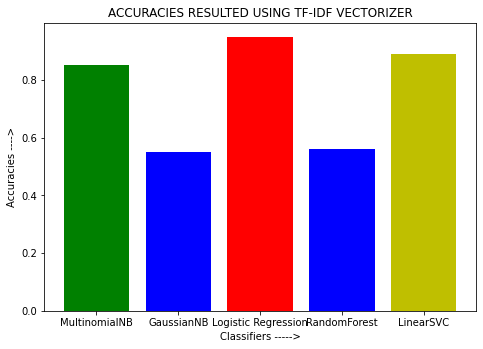

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
algo = ['MultinomialNB', 'GaussianNB', 'Logistic Regression', 'RandomForest', 'LinearSVC']
accuracy = [0.85,0.55,0.95,0.56,0.89]
ax.bar(algo[0],accuracy[0],color = 'g')
ax.bar(algo[1],accuracy[1],color = 'b')
ax.bar(algo[2],accuracy[2],color = 'r')
ax.bar(algo[3],accuracy[3],color = 'b')
ax.bar(algo[4],accuracy[4],color = 'y')
plt.xlabel('Classifiers ----->')
plt.ylabel('Accuracies ---->')
plt.title('ACCURACIES RESULTED USING TF-IDF VECTORIZER')
plt.show()

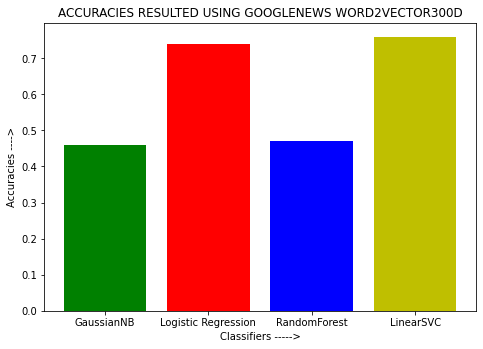

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
algo = ['GaussianNB', 'Logistic Regression', 'RandomForest', 'LinearSVC']
accuracy = [0.46,0.74,0.47,0.76]

ax.bar(algo[0],accuracy[0],color = 'g')
ax.bar(algo[1],accuracy[1],color = 'r')
ax.bar(algo[2],accuracy[2],color = 'b')
ax.bar(algo[3],accuracy[3],color = 'y')
plt.xlabel('Classifiers ----->')
plt.ylabel('Accuracies ---->')
plt.title('ACCURACIES RESULTED USING GOOGLENEWS WORD2VECTOR300D')
plt.show()

In [ ]:
Customer_Complaint='''
Omg where is my money?????? AOSINIONSAD WHY DID YOU GUYS TAKE MY MONEY AWAY. SAOIDNSIOADNOIAODNNIOASDNSADNOSDNOASDN
I TRANSFERRED IT LAST NIGHT AND I WOKE UP TO NOTHING IN!!!!!! MY BANK ACCOUNT. HELP PLEASE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
I NEED THE MONEY OR ELSE I WILL BE HUNTED BY LOAN SHARKS!!!!!!!!
YOU *(#&$) PEOPLE HAVE NO RIGHT TO DO THIS TO ME!!!! I NEED MY MONEY!!!!
'''
print(pred)


Omg where is my money?????? AOSINIONSAD WHY DID YOU GUYS TAKE MY MONEY AWAY. SAOIDNSIOADNOIAODNNIOASDNSADNOSDNOASDN
I TRANSFERRED IT LAST NIGHT AND I WOKE UP TO NOTHING IN!!!!!! MY BANK ACCOUNT. HELP PLEASE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
I NEED THE MONEY OR ELSE I WILL BE HUNTED BY LOAN SHARKS!!!!!!!!
YOU *(#&$) PEOPLE HAVE NO RIGHT TO DO THIS TO ME!!!! I NEED MY MONEY!!!!

Money tranfers: 35.25%
Loan: 18.82%
Mortgage: 12.65%
Bank account or service: 9.88%
Checking or saving account: 8.94%
Prepaid card: 5.66%
Other financial service: 3.59%
debt collection: 2.27%
